<a href="https://colab.research.google.com/github/yogesh1q2w/Dynamic-Graph-Algorithms/blob/master/GridWorld_Tabular_No_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from collections import defaultdict
import random

In [0]:
def printgrid(grid):
    plt.pcolormesh(grid,cmap = 'Greys', edgecolors = 'black')
    plt.axes().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.axes().invert_yaxis()
    plt.show()

def matfromfile(file):
    with open(file,'r') as f:
        s = []
        t = []
        r = f.read()
        f.close()
        l = 0
        tt = 0
        for j in r:
            if(j == '\n'):
                s.append(t)
                t = []
                tt = 0
                l += 1
            else:
                tt += 1
                if j == '2':
                    end = np.array([l,tt])
                t.append(int(j))
        s.append(t)
        return np.array(s),end


In [0]:
class GridEnv:
    def __init__(self,file, det=True):
        self.gridfile = file
        self.determ = det
        self.grid, self.goal = matfromfile(self.gridfile) 
        self.nstates = np.size(self.grid)
        self.nactions = 4
        self.actions = ['l','r','u','d']
        self.nrows = np.shape(self.grid)[0]
        self.ncols = np.shape(self.grid)[1]
        self.End = False
        self.start = [np.random.randint(0,self.nrows),np.random.randint(0,self.ncols)]
        while(self._gridval(self.start) == 0 or self._isEnd(self.start)):
          self.start = [np.random.randint(0,self.nrows),np.random.randint(0,self.ncols)]
        self.curr_state = self.start
        
    def _gridval(self,state):
        return self.grid[state[0], state[1]]
        
    def _reward(self,state):
        
        if self.grid[state[0],state[1]] == 2:
            return +5
        elif self._gridval(state) == 0:   
            return -2
        else:
            return -1
        
    def _isEnd(self,state):
        if (self.grid[state[0], state[1]] == 2):
          self.End = True
        else:
          self.End = False
        return self.End
        
    def _nonDeterminsticTrans(self,action):
        if action == 'u':
            return np.random.choice(['u','l','r'], p = [0.8,0.1,0.1])
        
        if action == 'd':
            return np.random.choice(['d','l','r'], p = [0.8,0.1,0.1])
        
        if action == 'l':
            return np.random.choice(['l','u','d'], p = [0.8,0.1,0.1])
        
        if action == 'r':
            return np.random.choice(['r','u','d'], p = [0.8,0.1,0.1])
        
    def sense(self,k):
        s = self.curr_state
        up = np.flip(self.grid[max(0,s[0]-k):s[0],s[1]])
        down = self.grid[s[0]+1:min(self.nrows,s[0]+k+1),s[1]]
        left = np.flip(self.grid[s[0],max(0,s[1]-k):s[1]])
        right = self.grid[s[0],s[1]+1:min(self.ncols,s[1]+k+1)]
        
        if(np.size(up) > 0):
            zr = np.where(up == 0)
            if(np.size(zr) == 0):
                filtup = up
            else:
                filtup = up[0:np.amin(zr)]
        else:
            filtup = np.array([])
            
        if(np.size(down) > 0):
            zr = np.where(down == 0)
            if(np.size(zr) == 0):
                filtdown = down
            else:
                filtdown = down[0:np.amin(zr)]
        else:
            filtdown = np.array([])
            
        if(np.size(left) > 0):
            zr = np.where(left == 0)
            if(np.size(zr) == 0):
                filtleft = left
            else:
                filtleft = left[0:np.amin(zr)]
        else:
            filtleft = np.array([])
            
        if(np.size(right) > 0):
            zr = np.where(right == 0)
            if(np.size(zr) == 0):
                filtright = right
            else:
                filtright = right[0:np.amin(zr)]
        else:
            filtright = np.array([])
            
            
        return np.array([filtup,filtdown,filtleft,filtright])
        
    def transition(self, action):
        if self.determ:
            if action == 'u':
                nextState = self.curr_state + np.array([-1,0])
            elif action == 'd':
                nextState = self.curr_state + np.array([1,0])
            elif action == 'l':
                nextState = self.curr_state + np.array([0,-1])
            elif action == 'r':
                nextState = self.curr_state + np.array([0,1])
                
        else:
            action = self._nonDeterminsticTrans(action)
            self.determ = True
            nextState,_,_ = self.transition(action)
            self.determ = False
            
#         print(nextState)
        if (nextState[0] >= 0) and (nextState[0] < self.nrows):
            if (nextState[1] >= 0) and (nextState[1] < self.ncols):
              if (self._gridval(nextState) != 0):
                self.curr_state = nextState
                return nextState,self._reward(nextState),self._isEnd(nextState)
              else:
                return self.curr_state,self._reward(nextState),self._isEnd(self.curr_state)
        
        return self.curr_state, self._reward(self.curr_state), self._isEnd(self.curr_state)
        
    def showBoard(self):
        printgrid(self.grid)
             
    def reset(self):
        self.start = np.array([np.random.randint(0,self.nrows),np.random.randint(0,self.ncols)])
        while(self._gridval(self.start) == 0 or self._isEnd(self.start)):
          # print(self.start)
          self.start = np.array([np.random.randint(0,self.nrows),np.random.randint(0,self.ncols)])
        self.curr_state = self.start
        self.End = False
            

In [0]:
class SimpleAgent:
    
    def __init__(self, sense):
        self.senseCap = sense
        self.actions = [0,1,2,3]
        self.actd = {0:'u',1:'d',2:'l',3:'r'}
        self.actrev = {'u':0,'d':1,'l':2,'r':3}

        self.lr = 0.2
        self.epsilon = 0.1
        self.gamma = 0.9
        self.Q_vals = defaultdict(lambda:[0.0,0.0,0.0,0.0])
    
    def learn(self, s, a, r, next_s):
        a = self.actrev[a]
        current_q = self.Q_vals[s][a]
        new_q = r + self.gamma * max(self.Q_vals[next_s])
        self.Q_vals[s][a] += self.lr * (new_q - current_q)


    def pick_action(self, state, senseRes):

        if np.random.rand() < self.epsilon:
            safeExps = []
            for i in range(0,4):
              if len(senseRes[i] > 0):
                safeExps.append(i)
                    
            action = np.random.choice(safeExps)

        else:
            state_action = self.Q_vals[state]
            action = self.arg_max(state_action)

        return self.actd[action]

    @staticmethod
    def arg_max(state_action):
        '''
            Select a random action from a list of actions with
            equal Q values from a state
        '''
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

In [0]:
env = GridEnv('50map.txt',False)
agent = SimpleAgent(3)
n_epis = 10000
nrow = env.nrows
ncol = env.ncols
max_len= 10000
learn_steps = 5

plot_rwds = []
for episode in range(0,n_epis,learn_steps):

  for _ in range(0,learn_steps):
    env.reset()
    epi_len  = 0
    while True:
      state = env.curr_state
      # print(episode,state)
      sensorRes = env.sense(agent.senseCap)
      action = agent.pick_action(str(state),sensorRes)
      next_state, rwd, done = env.transition(action)

      agent.learn(str(state),action,rwd,str(next_state))

      state = next_state
      epi_len += 1
          
      if done or epi_len > max_len:
        break

  env.start = [48,1]
  env.curr_state = env.start
  env.End = False
  epi_len = 0
  epi_rwd = 0
  while True:
    state = env.curr_state
    # print(episode,state)
    sensorRes = env.sense(agent.senseCap)
    action = agent.pick_action(str(state),sensorRes)
    next_state, rwd, done = env.transition(action)
    epi_rwd += rwd

    agent.learn(str(state),action,rwd,str(next_state))

    state = next_state
    epi_len += 1
        
    if done:
        plot_rwds.append(epi_rwd)
        break


  print('Episode# ', episode, ' , Episode stats: ', epi_rwd, '/' , epi_len)

Episode#  0  , Episode stats:  -2346 / 2352
Episode#  5  , Episode stats:  -4423 / 4429
Episode#  10  , Episode stats:  -7259 / 7265
Episode#  15  , Episode stats:  -11342 / 11348
Episode#  20  , Episode stats:  -3343 / 3349
Episode#  25  , Episode stats:  -15820 / 15826
Episode#  30  , Episode stats:  -4098 / 4104
Episode#  35  , Episode stats:  -6443 / 6449
Episode#  40  , Episode stats:  -8498 / 8504
Episode#  45  , Episode stats:  -7535 / 7541
Episode#  50  , Episode stats:  -3801 / 3807
Episode#  55  , Episode stats:  -1884 / 1890
Episode#  60  , Episode stats:  -6537 / 6543
Episode#  65  , Episode stats:  -3472 / 3478
Episode#  70  , Episode stats:  -4927 / 4933
Episode#  75  , Episode stats:  -4456 / 4462
Episode#  80  , Episode stats:  -5419 / 5425
Episode#  85  , Episode stats:  -2705 / 2711
Episode#  90  , Episode stats:  -10850 / 10856
Episode#  95  , Episode stats:  -4405 / 4411
Episode#  100  , Episode stats:  -2966 / 2972
Episode#  105  , Episode stats:  -1886 / 1892
Epis

In [0]:
def proc(rews,k = 5):
    prews = []
    for i in range(0,len(rews),k):
        prews.append(sum(rews[i:i+k])/k)
    return prews

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.save('/content/drive/My Drive/Planning Project/plots/GridWorld-Tabular-Stochastic-No_model_50map.npy',plot_rwds)

Text(0, 0.5, 'Average Reward')

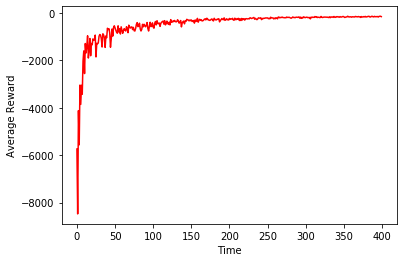

In [0]:
rs = proc(plot_rwds,5)
plt.plot(rs,'r-')
plt.xlabel('Time')
plt.ylabel('Average Reward')

In [0]:
env.curr_state = np.array([1,1])
env.sense(3)